# Machine Learning - Master IEF Parcours Quantitatif
## Prediction of Sharpe ratio for blends of quantitative strategies par Napoleon X (2019)
### Giovanni MANCHE et Antonin DEVALLAND

Lien vers le GitHub du projet : https://github.com/GiovanniManche/MachineLearning272

## Table des matières
J'arrive pas à la mettre   + faudra suivre l'outline donnée dans Moodle

## 1. Sujet

### 1.1. Contexte

Le sujet que nous avons choisi de traiter concerne la prédiction du ratio de Sharpe d'un mix de stratégies quantitatives, *Challenge Data du Collège de France* proposé par Napoleon X.
Lien : https://challengedata.ens.fr/participants/challenges/13/

Napoleon Crypto (NC), branche de Napoleon X, est une entreprise spécialisée dans la conception de solutions d'investissement quantitatives, basées sur des algorithmes. Ayant développé plusieurs stratégies performantes, NC cherche à optimiser l'allocation entre ces stratégies pour maximiser les performances. L'objectif de ce problème est donc d'aider à la construction d'un **mélange optimal de stratégies quantitatives d'investissement** à partir de l'ensemble des stratégies soumises. Trouver la meilleure allocation parmi les stratégies quantitatives chaque semaine revient à déterminer la combinaison maximisant le ratio de Sharpe (sur les 5 prochains jours de trading). Avec $Lr_{i,s}$ les rendements logarithmiques d'une stratégie $i$ à un temps $s$, le ratio de Sharpe annualisé objectif est calculé selon la formule suivante (il est légèrement modifié pour éviter une volatilité trop proche de 0) : 
$$
S_t^*(w_1, \ldots, w_7) = \frac{\frac{252}{5} \sum_{i=1}^{7} w_i \times \left( \sum_{s=t+1}^{t+5} Lr_{i,s} \right)}{Max \left( \sqrt{252 \times \sum_{i=1}^{7} \sum_{j=1}^{7} w_i w_j \sum_{s=t-20}^{t+5} (Lr_{i,s} - \bar{Lr_i})(Lr_{j,s} - \bar{Lr_j})} ; 0.005 \right)}
$$

L'enjeu est donc, finalement, de prédire le ratio de Sharpe $S^*$ d'une combinaison donnée de poids et d'optimiser en tenant compte du compromis rendement / volatilité. 

### 1.2. Description des données
Pour répondre à ce sujet, Napoleon X nous fournit des données concernant 7 stratégies quantitatives qu'ils ont mis en place. Pour chaque stratégie et chaque observation ("sample") nous sont fournit les poids alloués à chaque stratégie, la valeur de chacune des stratégies sur 21 jours de trading, et les valeurs de 3 instruments financiers (inconnus) sur 21 jours de trading. Dans un même sample, les jours de trading sont identiques, mais entre les samples, ces jours sont, logiquement, différents. Nous avons à notre disposition trois fichiers CSV contenant : 
- les données d'entraînement (10 000 observations par variable). Les poids alloués aux stratégies, les valeurs des stratégies et les valeurs des instruments financiers représentent nos *features*.
- les données de test (4 450 observations par variable)
- les valeurs du label (ratio de Sharpe, 10 000 valeurs cibles)

Les données d'entraînement et de test sont organisées de la façon suivante : 
- la première colonne correspond à l'ID de l'observation,
- les 7 colonnes suivantes correspondent aux poids alloués aux 7 stratégies qui nous sont proposées,
- les colonnes suivantes correspondent aux valeurs des autres *features* sur 21 jours de trading (séries temporelles). On a donc 21 colonnes par stratégie, et par produit financiers, soit un total de : 
$$
\underbrace{1}_{ID} + \underbrace{7}_{\text{Poids}} + \underbrace{7 \times 21}_{\text{Valeurs des stratégies sur 21 jours}} + \underbrace{3 \times 21}_{\text{Valeurs des instruments sur 21 jours}} = 218 \text{ colonnes}  
$$
Les valeurs des stratégies et des instruments financiers sont normalisées à 100 au départ ($lag_{21}$). Les poids sont strictement positifs et somment à 1. Matriciellement, notre ensemble d'entraînement se représente par :
$$
X =
\begin{bmatrix}
w_1^{(1)} & w_2^{(1)} & \dots & w_7^{(1)} & I_1^{(1,t-20)} & I_1^{(1,t-19)} & \dots & I_1^{(1,t)} & \dots & I_7^{(1,t-20)} & \dots & I_7^{(1,t)} & X_1^{(1,t-20)} & \dots & X_3^{(1,t)} \\
w_1^{(2)} & w_2^{(2)} & \dots & w_7^{(2)} & I_1^{(2,t-20)} & I_1^{(2,t-19)} & \dots & I_1^{(2,t)} & \dots & I_7^{(2,t-20)} & \dots & I_7^{(2,t)} & X_1^{(2,t-20)} & \dots & X_3^{(2,t)} \\
\vdots & \vdots & \dots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
w_1^{(10000)} & w_2^{(10000)} & \dots & w_7^{(10000)} & I_1^{(10000,t-20)} & I_1^{(10000,t-19)} & \dots & I_1^{(10000,t)} & \dots & I_7^{(10000,t-20)} & \dots & I_7^{(10000,t)} & X_1^{(10000,t-20)} & \dots & X_3^{(10000,t)}
\end{bmatrix}, 
\ Y = \begin{bmatrix}
SR_1 \\
SR_2 \\
\vdots \\
SR_{10000}
\end{bmatrix}
$$

### 1.3. Description du benchmark

Chaque modèle proposé produira *in fine* des valeurs de ratio de Sharpe selon la formule présentée plus haut, et sera comparée aux vraies valeurs du ratio de Sharpe. Avant la comparaison, une fonction de lissage des extrêmes est appliquée aux résultats : 
$$
f(x) = sign(x) \times e^{-\frac{1}{abs(x)}}
$$
Une fois les résultats lissés, la métrique / fonction de perte retenue est la moyenne des erreurs absolues : 
$$
d(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N |f(y_i) - f(\hat{y_i})|
$$

Le benchmark proposé est de 1.200344, et correspond en fait à la moyenne des ratios de Sharpe du set d'entraînement. Outre la simplicité de calcul de ce benchmark, surpasser la moyenne du set d'entraînement est le strict minimum pour que notre modèle ait un intérêt pratique.

## 2. Problématique

Ce sujet permet ainsi de faire appel au machine learning pour proposer une réponse à une problématique absolument cruciale pour tout gestionnaire : comment optimiser l'allocation des différentes stratégies d'investissement quantitatives pour maximiser le ratio de Sharpe, ou dit plus simplement, comment ajuster le niveau d'*asset under management* au sein d'une même société de gestion entre les différentes stratégies pour maximiser la performance.

Le passage du problème financier au problème de machine learning se pose formellement. Ici, nous allons faire de l'apprentissage supervisé, le label nous étant fourni. Le label (ratio de Sharpe) peut *théoriquement* prendre ses valeurs dans $\mathbb{R}$, nous sommes donc face à un **problème de régression**. Avec $X \in \mathcal{X}$ les *features* (poids, valeurs des stratégies, valeurs des instruments, soit $7 + 7 \times 21 + 3 \times 21 = 217$ *features*) et $Y \in \mathcal{Y}$ les labels (ici, uniquement le ratio de Sharpe), on cherche $h_{\theta}^*$ la meilleure approximation de la fonction de mapping $\phi : \mathcal{X} \rightarrow \mathcal{Y}$ définie telle que 
$$ y_i = \phi(x_i) + \varepsilon_i \ \forall i = {1,...,n}$$

Notre espace d'hypothèses, $\mathcal{H}$, est définissable comme l'ensemble des fonctions $f : \mathbb{R^{17}} \rightarrow \mathbb{R}$. La fonction de coût nous est imposée, il s'agit de la moyenne des erreurs absolue.

## 3. Récupération et préparation des données

### 3.1. Import des bibliothèques nécessaires 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import kruskal
from itertools import combinations
#import warnings
#warnings.filterwarnings("ignore")

### 3.2 Import des données et nettoyage

Le fichier CSV fournit pour l'entraînement pesait trop lourd (plus de 35 000 Ko, alors que la limite pour déposer les données sur GitHub est de 25 000 Ko). Nous l'avons donc converti en un fichier xlsx., moins lourd, au prix d'un temps d'importation via Python allongé.

In [2]:
train_set: pd.DataFrame = pd.read_excel("Data/Train set.xlsx")
test_set: pd.DataFrame = pd.read_csv("Data/Test set.csv")
target_values: pd.DataFrame = pd.read_csv("Data/Target values.csv")

Nous effectuons quelques vérifications pour s'assurer que le jeu de données est utilisable : 
- gestion des données manquantes
- gestion des données dupliquées
- uniformisation des formats de données
- gestion des outliers

Tout d'abord, on s'assure que les fichiers ne présentent pas de lignes dupliquées.

In [3]:
print(f"Les dimensions du train set initial sont {train_set.shape} et celles du nouveau train set sont de {train_set.drop_duplicates().shape}.")
print(f"Les dimensions du train set initial sont {test_set.shape} et celles du nouveau train set sont de {test_set.drop_duplicates().shape}.")
print(f"Les dimensions du train set initial sont {target_values.shape} et celles du nouveau train set sont de {target_values.drop_duplicates().shape}.")

Les dimensions du train set initial sont (10000, 218) et celles du nouveau train set sont de (10000, 218).
Les dimensions du train set initial sont (4450, 218) et celles du nouveau train set sont de (4450, 218).
Les dimensions du train set initial sont (10000, 2) et celles du nouveau train set sont de (10000, 2).


Ensuite, on vérifie l'absence de données manquantes.

In [4]:
print(f"Le fichier contenant les données d'entraînement contient {train_set.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les données de test contient {test_set.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les valeurs cibles contient {target_values.isnull().sum().sum()} données manquantes.")

Le fichier contenant les données d'entraînement contient 0 données manquantes.
Le fichier contenant les données de test contient 0 données manquantes.
Le fichier contenant les valeurs cibles contient 0 données manquantes.


À toutes fins utiles, on s'assure que nos données sont toutes de type float. En effet, le train set et test set sont composés de valeurs décimales (parts, valeurs des stratégies, valeurs des instruments financiers), il n'y a donc pas de raison qu'elles soient autre chose que de type float.

In [5]:
train_set = train_set.astype(float)
target_values = target_values.astype(float)
test_set = test_set.astype(float)

In [6]:
target_values

,ID,Target
0,0.0,-12.007941
1,1.0,2.294867
2,2.0,0.652308
3,3.0,2.412364
4,4.0,8.517471
...,...,...
9995,9995.0,1.455430
9996,9996.0,-1.532292
9997,9997.0,3.496214
9998,9998.0,2.764467


On peut désormais faire quelques vérifications sur les valeurs : 
- les valeurs des parts doivent être comprises entre 0 et 1 (répartition de l'AUM entre différentes stratégies)
- la somme des parts doit être égale à 1 (tolérance de $10^{-4}$)
- les valeurs initiales des stratégies et des instruments financiers doivent être égales à 100 (initialisation)


In [7]:
# Tests sur les poids
weights_train = train_set.iloc[:,1:8]
weights_test = test_set.iloc[:, 1:8]
# Ensemble d'entraînement
print(f"Dans le set d'entraînement, {((weights_train < 0) | (weights_train > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set d'entraînement, {abs((weights_train.sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")
# Ensemble de test
print(f"Dans le set de test, {((weights_test < 0) | (weights_test > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set de test, {abs((weights_test.sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")


Dans le set d'entraînement, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set d'entraînement, 0 samples ont une somme totale de poids différents de 1
Dans le set de test, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set de test, 0 samples ont une somme totale de poids différents de 1


In [8]:
# Tests sur les valeurs initiales
init_train = train_set.filter(like = 'lag_20')
init_test = test_set.filter(like = 'lag_20')
print(f"Dans le set d'entraînement, {((init_train != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")
print(f"Dans le set de test, {((init_test != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")

Dans le set d'entraînement, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100
Dans le set de test, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100


Il reste finalement la gestion des outliers à traiter. Concrètement, dans le train set, de potentielles outliers sont présents. Le ratio de Sharpe (target value) doit contenir sensiblement les mêmes outliers, puisqu'il est calculé sur les bases des rendements du pool de stratégies du train set. Pour identifier si un travail sur les outliers est utile, regardons le boxplot et l'histogramme des ratios de Sharpe : 

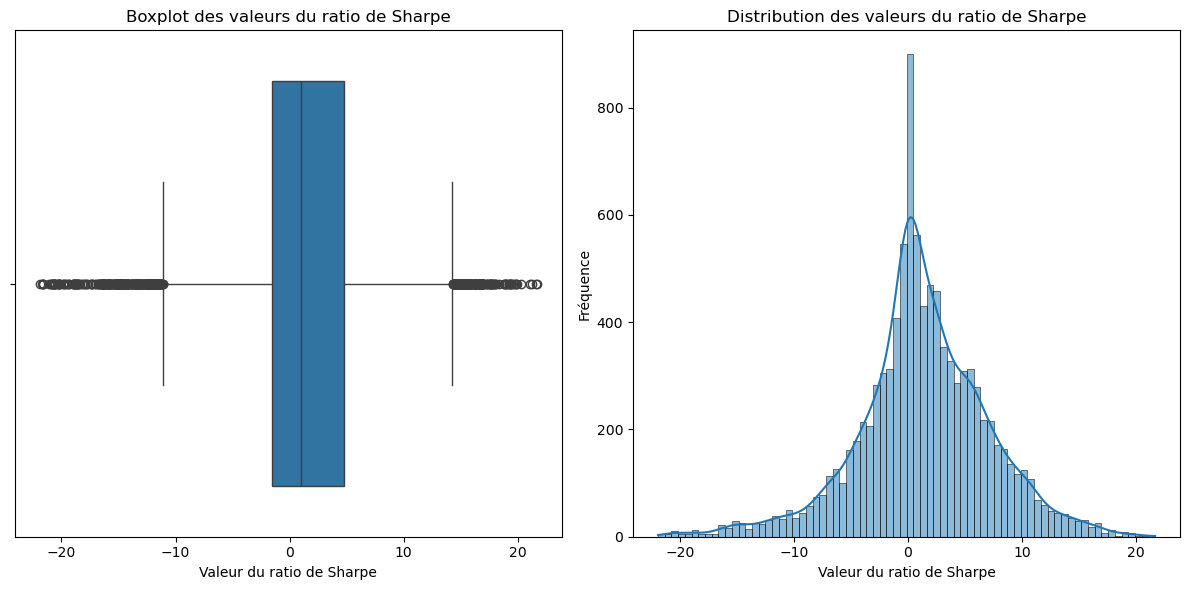

In [9]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=target_values["Target"])
plt.xlabel("Valeur du ratio de Sharpe")
plt.title('Boxplot des valeurs du ratio de Sharpe')

# Histogramme
plt.subplot(1, 2, 2)
sns.histplot(target_values["Target"], kde=True)
plt.xlabel("Valeur du ratio de Sharpe")
plt.ylabel("Fréquence")
plt.title('Distribution des valeurs du ratio de Sharpe')

plt.tight_layout()
plt.show()

Ces graphiques sont particulièrement éloquents : il existe un nombre non négligeable de valeurs en dehors des premier et troisième quartiles, et il convient de les supprimer pour éviter d'éventuels biais. Pour cela, nous utilisons la méthode interquartile pour la gestion des valeurs extrêmes : 
- nous calculons l'écart interquartile $IQR = Q_3 - Q_1$,
- nous calculons les bornes de l'intervalle $[Q_1 - 1.5 \times IQR, \ Q_3 + 1.5 \times IQR]$,
- nous supprimons toute valeur en dehors de l'intervalle. 

In [10]:
# Calcul des bornes de l'intervalle
Q1 = target_values["Target"].quantile(0.25)
Q3 = target_values["Target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Récupération des outliers et des IDs correspondant (sont identiques entre target_values et train_set)
outliers = (target_values["Target"] < lower_bound_iqr) | (target_values["Target"] > upper_bound_iqr)
outlier_indices = target_values[outliers].index
outlier_ids = target_values.loc[outlier_indices, "ID"].values
pct_outliers = len(outlier_ids)/len(target_values) * 100
print(f"Nombre d'outliers identifiés : {len(outlier_ids)} ({pct_outliers:.2f}%)")

# Récupération des données excluant les outliers
target_values_clean = target_values[~outliers].reset_index(drop=True)
ids_to_keep = target_values[~outliers]["ID"].values
train_mask = train_set["ID"].isin(ids_to_keep)                  
train_set_clean = train_set[train_mask].reset_index(drop=True)

print(f"\nDimensions avant suppression des outliers :") ; print(f"train_set: {train_set.shape}") ; print(f"target_values: {target_values.shape}")
print(f"\nDimensions après suppression des outliers:") ; print(f"train_set_clean: {train_set_clean.shape}") ; print(f"target_values_clean: {target_values_clean.shape}")

# On s'assure que les ID du train set et des target values correspondent 
are_ids_same = np.array_equal(train_set_clean["ID"].values, target_values_clean["ID"].values)   # Renvoie true si c'est le cas
print(f"\nLes ID sont identiques dans les deux datasets purgés des outliers : {are_ids_same}")


Nombre d'outliers identifiés : 463 (4.63%)

Dimensions avant suppression des outliers :
train_set: (10000, 218)
target_values: (10000, 2)

Dimensions après suppression des outliers:
train_set_clean: (9537, 218)
target_values_clean: (9537, 2)

Les ID sont identiques dans les deux datasets purgés des outliers : True


Maintenant que nous avons des données traitées, nous pouvons les analyser pour elle-même.

### 3.3. Analyse exploratoire

#### 3.3.1. Etudes descriptives des features

Nous pouvons d'abord présenter différentes statistiques descriptives concernant les données de l'ensemble d'entraînement. On conserve volontairement les poids (pour observer une éventuelle surpondération systématique d'une stratégie, qui viendrait biaiser la procédure), et excluons les colonnes dont le nom contient `'lag_20'`, invariantes et fixées à 100  : 

In [11]:
cols_lag_20 = [col for col in train_set_clean.columns if "lag_20" in col]
cols_lag_20.append("ID")
descriptive_stat_train = train_set_clean.drop(columns= cols_lag_20).describe()
display(descriptive_stat_train)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,...,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,0.140112,0.144804,0.137428,0.143614,0.148081,0.140951,0.145009,100.001830,100.036588,100.029606,...,100.123026,100.139334,100.196220,100.231320,100.241656,100.231681,100.251471,100.285095,100.261162,100.334251
std,0.240415,0.241895,0.236855,0.243023,0.243745,0.237920,0.241514,0.352727,0.469260,0.602617,...,1.224083,1.309649,1.384940,1.405158,1.454149,1.505610,1.588537,1.686289,1.715535,1.786217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.433199,98.207613,97.537396,...,95.431478,95.979716,95.979716,96.599608,96.478804,96.341153,96.449968,95.723877,95.642353,94.714651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.942373,99.882164,99.884263,...,99.170771,99.263834,99.283351,99.279821,99.293031,99.138246,99.138246,99.180329,99.007832,99.147607
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.014325,100.036731,...,100.236547,100.246618,100.351856,100.364852,100.364844,100.474505,100.426310,100.572613,100.502408,100.586383
75%,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,100.094607,100.161242,100.296274,...,100.914138,100.964410,101.024243,101.110801,101.165162,101.210557,101.245583,101.237357,101.256881,101.452329
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.475880,101.350831,101.881236,...,103.869008,104.767236,105.458086,106.757012,106.549721,105.582424,107.157708,108.207867,108.207867,108.677631


Concentrons nous d'abord sur les poids. On remarque que ces derniers semblent globalement équirépartis sur l'ensemble d'entraînement (moyenne à presque $0.14 \approx \frac{1}{7}$ pour les 7 stratégies). Cela est une bonne nouvelle, puisque la surpondération systématique d'une stratégie aurait réduit l'intérêt des poids dans le travail d'entraînement, alors que le coeur du sujet réside ici (si une stratégie est pondérée en moyenne à 80%, elle expliquera presque systématiquement le ratio de Sharpe). Par ailleurs, ils ont à peu près tous un écart-type de 24%. Cette variabilité uniforme est également rassurante, puisque nous n'avons pas des poids quasi-statiques d'une part, et des poids aléatoires d'autre part. 

Concentrons nous ensuite sur les valeurs des stratégies et des instruments financiers. On s'attend à ce que la volatilité aille croissant avec le temps (puisque les scénarios possibles se démultiplient). Il peut également être intéressant d'observer l'évolution de la valeur moyenne dans le temps : si les stratégies sont performantes, la moyenne devrait aussi augmenter. Pour voir cela, nous allons afficher les moyennes et volatilités dans le temps pour chaque valeur de stratégie et d'instruments.

In [12]:
# Etape 1 : création de fonctions connexes
# On cherche à extraire les moyennes et volatilité pour les valeurs d'une stratégie ou d'un instrument, puis à les représenter graphiquement
def extract_by_element_and_lag(stat: str =  'mean',desc_df: pd.DataFrame = descriptive_stat_train) -> pd.DataFrame :
    """
    Fonction qui récupère l'élément demandé dans un tableau de statistique descriptive. 
    Le tableau de sortie sera constitué d'une colonne correspondant à la valeur de la stratégie (I_1,...) ou de l'instrument (X_1,...),
    d'une colonne 'lag' et d'une colonne contenant les valeurs cherchées.
    """
    results = []
    for col in desc_df.columns:
        if '_lag_' in col:
            parts = col.split('_lag_')
            element = parts[0]
            lag = int(parts[1])
            results.append({
                'element': element,
                'lag': lag,
                stat: desc_df.loc[stat, col]
            })
            
    # Conversion en DataFrame
    result_df = pd.DataFrame(results)
    return result_df

# Fonction pour créer le graphique voulu
def create_line_chart(data: pd.DataFrame, stat: str, elements_I:list, elements_X: list, title: str, y_label: str) -> plt:
    plt.figure(figsize=(14, 8))
    
    # Palettes de couleurs distinctes (bleu pour les valeurs des stratégies, rouge pour celles des instruments)
    colors_I = plt.cm.Blues(np.linspace(0.4, 0.9, len(elements_I)))
    colors_X = plt.cm.Reds(np.linspace(0.4, 0.9, len(elements_X)))
    
    # On trace les lignes pour les valeurs des stratégies, puis celles des instruments
    for i, elem in enumerate(elements_I):
        subset = data[data['element'] == elem]
        subset_sorted = subset.sort_values('lag')  
        plt.plot(subset_sorted['lag'], subset_sorted[stat], 'o-', 
                 label=elem, color=colors_I[i], linewidth=2)
        
    for i, elem in enumerate(elements_X):
        subset = data[data['element'] == elem]
        subset_sorted = subset.sort_values('lag')  
        plt.plot(subset_sorted['lag'], subset_sorted[stat], 's-', 
                 label=elem, color=colors_X[i], linewidth=2)
    
    # Configurations générales
    plt.title(title, fontsize=16)
    plt.xlabel('Lag (0 = plus récent, 19 = plus ancien)', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(range(0, 20))
    plt.gca().invert_xaxis()  # On inverse l'axe pour que le temps aille de gauche à droite
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt

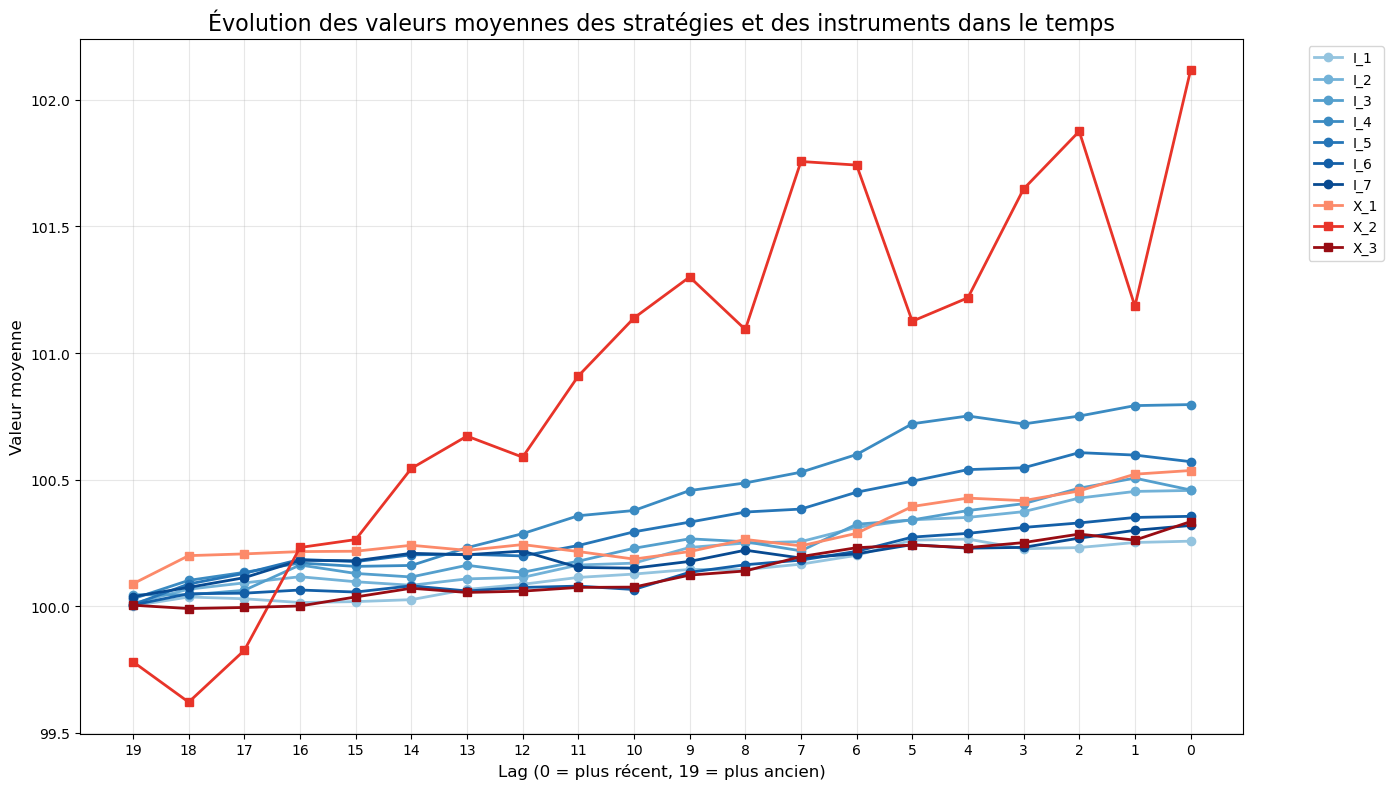

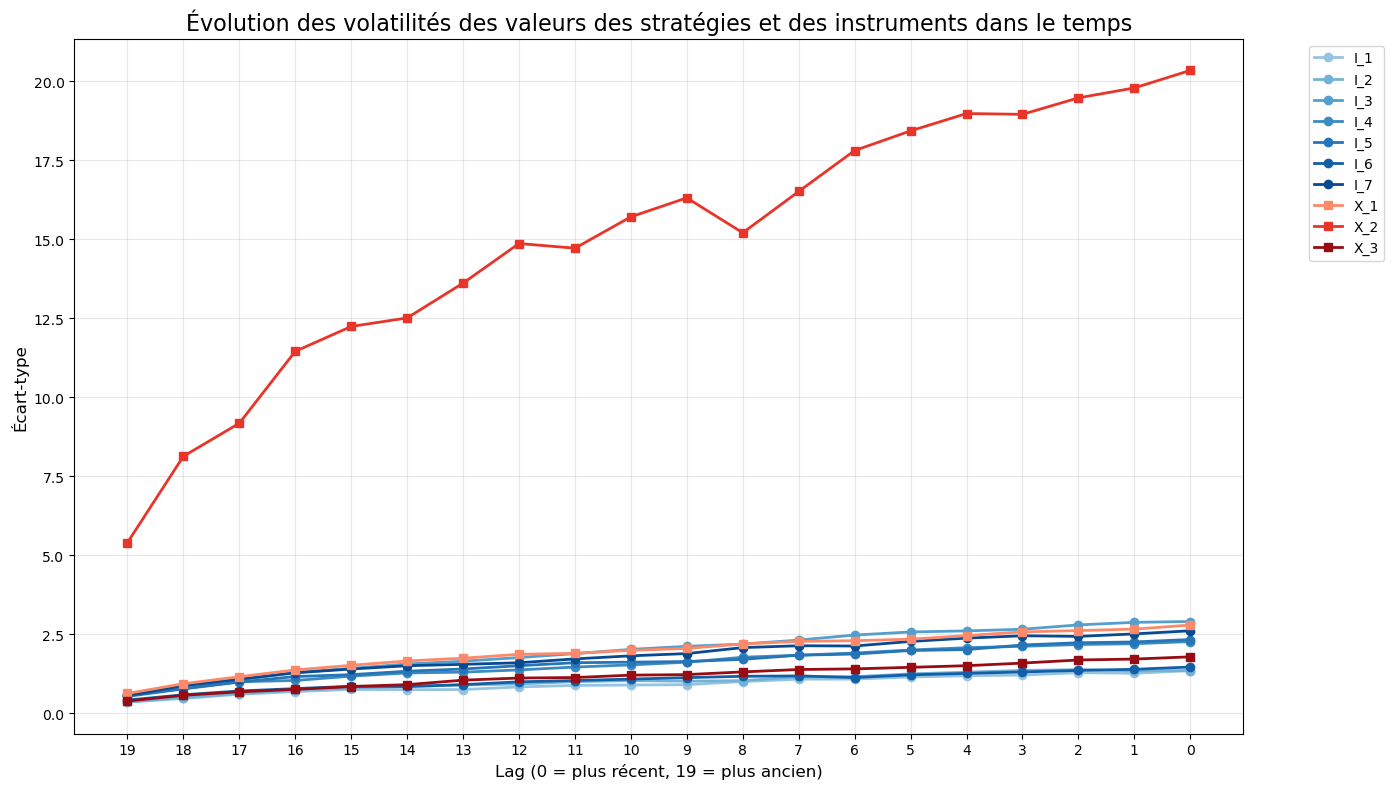

In [13]:
# Etape 2 : affichage
# On récupère les moyennes et écart-types par valeur de stratégie / d'instrument
means_by_element = extract_by_element_and_lag('mean',descriptive_stat_train)
volatility_by_element = extract_by_element_and_lag('std',descriptive_stat_train)

# Dans nos données, lag_19 correspond aux données les plus anciennes, lag_0 les données les plus récentes.
# Pour que les graphiques aient un sens logique, on doit inverser cela.
time_periods = sorted(means_by_element['lag'].unique())
time_map = {lag: 19-lag for lag in time_periods}  # lag_19 = temps 0

# On ajoute une colonne 'time' représentant le temps (inversé par rapport au lag)
means_by_element['time'] = means_by_element['lag'].map(time_map)

# On s'assure de ne récupérer que les valeurs des stratégies ou instruments
I_elements = [f'I_{i}' for i in range(1, 8)]
X_elements = [f'X_{i}' for i in range(1, 4)]
all_elements = I_elements + X_elements
filtered_means = means_by_element[means_by_element['element'].isin(all_elements)]
filtered_vol = volatility_by_element[volatility_by_element['element'].isin(all_elements)]

# On crée les graphiques des moyennes et des volatiltés
chart1 = create_line_chart(filtered_means, 'mean',  I_elements, X_elements, 
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
    )

chart2 = create_line_chart(filtered_vol, 'std', I_elements, X_elements, 
    'Évolution des volatilités des valeurs des stratégies et des instruments dans le temps',
    'Écart-type')

plt.show()

On observe globalement des comportements fidèles à ceux attendus : les portefeuilles alloués aux différentes stratégies s'apprécient, de même que les valeurs des instruments. Cela témoigne d'une bonne performance des stratégies, tandis que l'interprétation des instruments est plus ardue, ceux-ci n'étant pas connu. L'instrument 2 (X_2) ressort évidemment, et présente à la fois une volatilité largement plus élevée que les autres instruments, mais offre aussi un rendement sur 20 jours plus important en moyenne. Cela est en soit conforme à la théorie économique. L'instrument 2 ressort par son côté visiblement très risqué, et ce même sur une très courte période. En tout cas, ces éléments nous confirment la nécessité de standardiser nos données.

#### 3.3.2. Etudes descriptives de la variable cible



Nous présentons ci-dessous quelques éléments de statistiques descriptives sur la variable cible :

In [14]:
descriptive_stat_target = target_values_clean.drop(columns = "ID").describe()
display(descriptive_stat_target)

,Target
count,9537.000000
mean,1.527390
std,4.791512
min,-11.091926
25%,-1.263848
50%,1.049771
75%,4.671234
max,14.269829


Les ensembles de stratégies présentent un ratio de Sharpe annualisé moyen d'environ 1.5, ce qui se situe dans la tranche haute des valeurs usuelles des ratios de Sharpe. Mais ce qui est le plus frappant est tout de même la plage d'évolution de ce ratio, avec une étendue de plus de 26 points. On est donc face à des stratégies qui certes semblent très bien performer en moyenne, mais sont aussi très risquées. Cela se confirme par la volatilité du ratio de Sharpe. **Rappelon d'ailleurs que nous avons nettoyé nos données : les résultats sont encore plus frappants sur les données non nettoyées**.  

In [15]:
display(target_values.drop(columns = "ID").describe())

,Target
count,10000.000000
mean,1.288322
std,5.804263
min,-21.902900
25%,-1.569933
50%,0.983215
75%,4.778502
max,21.665272


On peut observer que notre nettoyage a bien fait décroître la volatilité, mais a accru le ratio de Sharpe. La conclusion naturelle est qu'un plus grand nombre de ratios de Sharpe négatifs ont été purgés. 

#### 3.3.3. Corrélation entre les features

Avant d'analyser la corrélation entre nos features et le label, intéressons-nous aux corrélations entre les features eux-mêmes. En effet, des corrélations inter-features trop fortes (ou, comme on raisonne avec des séries temporelles, des cas d'autocorrélation parfois) peut réduire l'interprétabilité (difficile d'isoler l'effet individuel de chaque feature sur la prévision) et la performance du modèle (certains algorithmes sont sensibles à la multicolinéarité). En outre, cela peut aussi faciliter l'overfitting. Nous en profitons pour formellement créer un dataframe sans les colonnes "ID" (aucun sens) et "lag_20" (identiques pour tout l'échantillon), et joignant les features et les labels. Nos séries étant toutes continues, on considère d'abord une corrélation "classique" (de Pearson).

In [16]:
# Copies de sécurité
train_set_clean = train_set_clean.copy()  
target_values_clean = target_values_clean.copy()  

# Jointure et exclusions 
merged_train_df = train_set_clean.join(target_values_clean["Target"])
merged_train_df = merged_train_df.drop(columns = cols_lag_20)
# On vérifie que le dataframe fusionné n'a plus d'ID, de lag_20, et contient "Target"
print("Set d'entraînement : ")
display(merged_train_df) 

# Corrélation linéaire 
train_correl = merged_train_df.corr()
print("Matrice de corrélation")
display(train_correl)

Set d'entraînement : 


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0,Target
0,0.00,0.00,0.00,0.40,0.25,0.00,0.35,99.912339,99.960558,100.182904,...,100.938707,100.993926,101.132016,100.745489,100.524617,100.303743,100.276090,100.303743,100.554527,2.294867
1,0.85,0.00,0.00,0.15,0.00,0.00,0.00,99.481681,100.199593,100.408011,...,100.581716,100.313489,100.790251,101.013756,100.686030,100.686030,100.060233,99.747384,99.970889,0.652308
2,0.00,0.00,0.70,0.05,0.25,0.00,0.00,100.124618,100.023384,100.296274,...,101.040072,101.055122,101.567682,101.703322,101.974603,101.733422,101.838963,102.080144,101.688272,2.412364
3,0.00,0.55,0.05,0.00,0.00,0.00,0.40,100.000000,99.407717,99.418545,...,99.482389,99.604192,100.030499,99.847797,100.426310,100.426310,100.822217,100.913521,100.852619,8.517471
4,0.10,0.00,0.00,0.00,0.00,0.00,0.90,100.830429,101.179770,100.923997,...,101.197305,101.771363,102.345411,102.657045,102.919468,102.804653,102.870260,102.952272,102.870260,1.039912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,0.50,0.00,0.00,0.45,0.00,0.00,0.05,100.133669,100.200489,100.185827,...,101.768901,101.825961,102.282452,103.280979,102.738943,102.510698,102.596243,103.280979,103.223917,1.455430
9533,0.50,0.00,0.15,0.35,0.00,0.00,0.00,100.830429,101.179770,100.923997,...,101.197305,101.771363,102.345411,102.657045,102.919468,102.804653,102.870260,102.952272,102.870260,-1.532292
9534,0.10,0.00,0.00,0.00,0.00,0.65,0.25,100.000000,99.981892,99.924140,...,98.527571,97.744362,98.088972,98.057644,98.214286,97.525063,97.274436,96.773184,96.804512,3.496214
9535,0.00,0.00,0.00,0.15,0.15,0.00,0.70,99.985526,100.019709,99.924834,...,102.017204,102.402799,102.210001,102.106150,101.438717,101.928162,102.032013,102.076533,102.402799,2.764467


Matrice de corrélation


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0,Target
weight_I_1,1.000000,-0.170304,-0.162741,-0.173987,-0.165698,-0.164071,-0.161340,-0.006633,-0.002663,0.004133,...,-0.008005,-0.004522,-0.010620,-0.014379,-0.018609,-0.017185,-0.015061,-0.013815,-0.012477,0.016323
weight_I_2,-0.170304,1.000000,-0.166152,-0.165893,-0.173793,-0.163938,-0.165274,0.010579,0.014715,0.011587,...,-0.008667,-0.005594,0.001017,0.002325,0.000282,0.002984,0.005638,0.005264,0.004338,0.035391
weight_I_3,-0.162741,-0.166152,1.000000,-0.163268,-0.157333,-0.163284,-0.168367,-0.003890,-0.010741,-0.009619,...,0.022684,0.022181,0.023451,0.025393,0.024364,0.019127,0.018195,0.019693,0.019694,-0.019942
weight_I_4,-0.173987,-0.165893,-0.163268,1.000000,-0.167378,-0.169774,-0.170607,0.007619,0.011216,0.003331,...,-0.004575,-0.009263,-0.005807,-0.004089,-0.002144,0.000224,-0.000725,0.001469,-0.004087,0.016268
weight_I_5,-0.165698,-0.173793,-0.157333,-0.167378,1.000000,-0.168682,-0.181333,-0.003281,-0.005595,-0.012530,...,0.004865,-0.001498,-0.002038,-0.005660,-0.002630,-0.003708,-0.003305,-0.001806,0.002042,-0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_3_lag_3,-0.017185,0.002984,0.019127,0.000224,-0.003708,0.007420,-0.008433,-0.054789,-0.008663,0.028420,...,0.834083,0.879566,0.907025,0.935263,0.968448,1.000000,0.967723,0.944777,0.912111,-0.017160
X_3_lag_2,-0.015061,0.005638,0.018195,-0.000725,-0.003305,0.008529,-0.012835,-0.042413,-0.015451,0.030006,...,0.801889,0.848912,0.879634,0.908216,0.932176,0.967723,1.000000,0.977032,0.941022,-0.012244
X_3_lag_1,-0.013815,0.005264,0.019693,0.001469,-0.001806,0.003289,-0.013728,-0.058829,-0.022037,0.025170,...,0.788105,0.832548,0.855604,0.884402,0.907032,0.944777,0.977032,1.000000,0.967016,-0.018936
X_3_lag_0,-0.012477,0.004338,0.019694,-0.004087,0.002042,0.003762,-0.012895,-0.070238,-0.031057,0.017970,...,0.782980,0.827481,0.836698,0.866510,0.877504,0.912111,0.941022,0.967016,1.000000,-0.039668


La représentation de la matrice de corrélation n'est pas simple étant donnée sa taille. Nous proposons deux approches : 
- une approche par heatmap usuelle sur la partie triangulaire inférieure de la matrice. C'est une solution peu fine mais qui permet de voir à vue d'oeil si les corrélations sont **globalement** fortes ou faibles entre les features ;
- un affichage de l'histogramme des corrélations. Si l'on s'aperçoit qu'un nombre conséquent de corrélations sont élevées, nous investiguerons davantage.

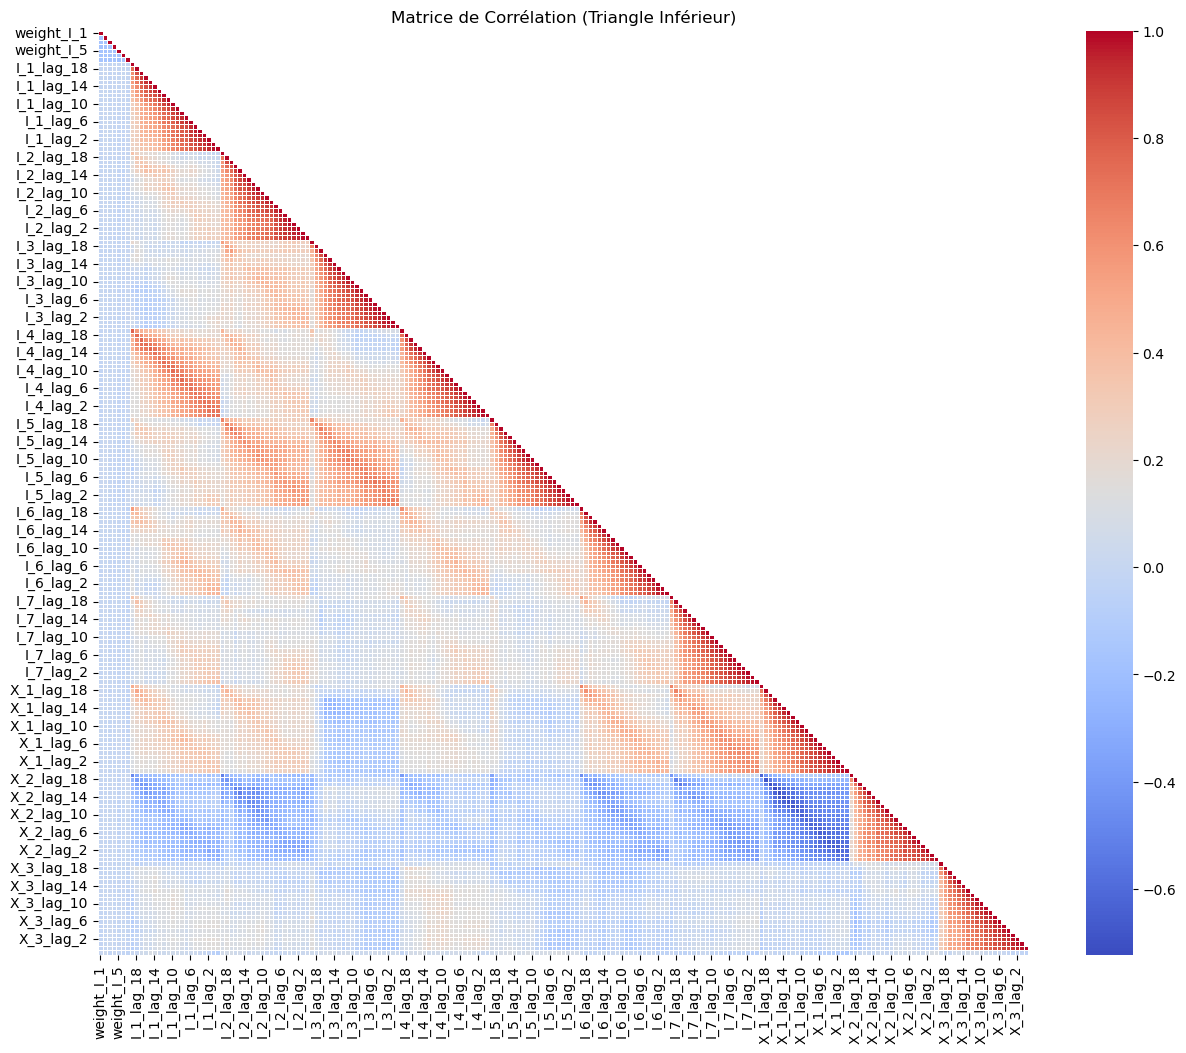

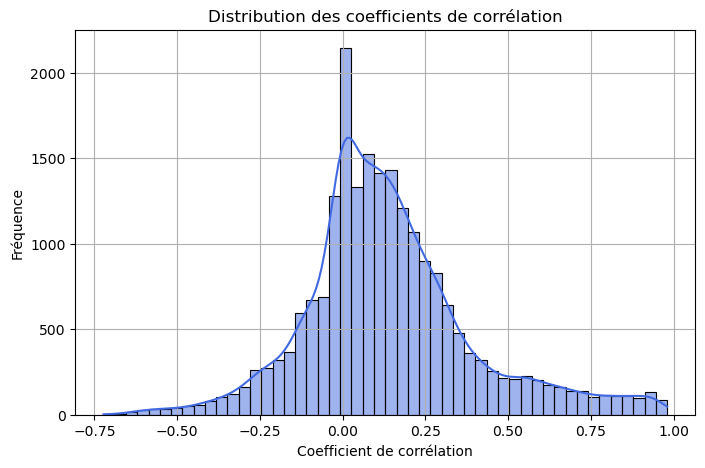

In [17]:
# Masque pour afficher uniquement la partie inférieure
train_correl_features_only = train_correl.drop(columns="Target")
mask = np.triu(np.ones_like(train_correl_features_only, dtype=bool), k=1)
# Heatmap 
plt.figure(figsize=(15, 12))
sns.heatmap(train_correl_features_only, mask=mask, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Matrice de Corrélation (Triangle Inférieur)")
plt.show()

# Histogramme
correlation_values = train_correl_features_only.values[mask]
plt.figure(figsize=(8,5))
sns.histplot(correlation_values, bins=50, kde=True, color="royalblue")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Fréquence")
plt.title("Distribution des coefficients de corrélation")
plt.grid()
plt.show()

De ces graphiques, nous pouvons faire deux principales remarques : 
- d'un côté, les séries temporelles ne semblent pas fortement corrélées entre elles et avec les poids (zones bleues). Cela est positif, puisque cela nous fait penser qu'elles n'expliquent pas les mêmes éléments. 
- d'un autre côté, de fortes corrélations positives existent au sein des séries temporelles. Cela fait clairement rapport avec de l'autocorrélation dans les séries de prix, ce qui est un phénomène connu des marchés. La différenciation permet généralement d'aboutir à des séries stationnaires non autocorrélées. Nous reviendrons plus en détail sur ces points dans la suite.

#### 3.3.4. Corrélations entre les features et la cible

Désormais, il convient d'analyser les corrélations entre les features et la cible. Si la corrélation ne doit pas être trop forte (sinon c'est que la cible et le feature sont colinéaires), elle doit néanmoins être significative pour que le feature ait un intérêt. Nous utilisons d'abord la corrélation de Pearson, nos séries étant toutes continues.

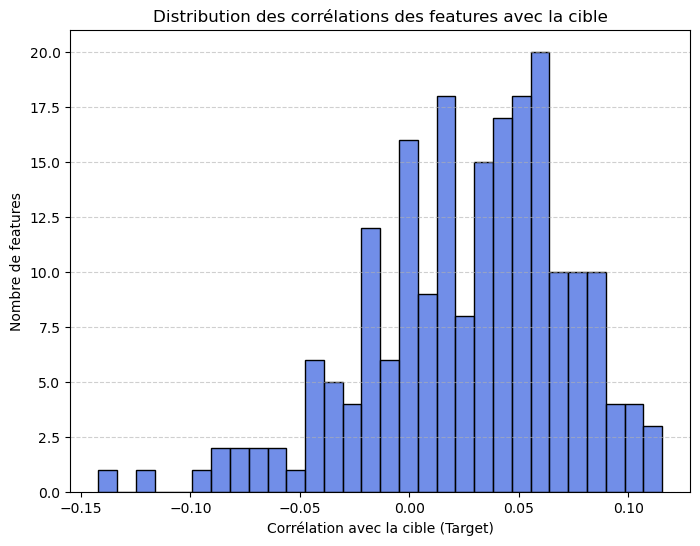

In [18]:
# Récupération des corrélations entre les features et le label
corr_target = train_correl["Target"].drop("Target")

# Histogramme
plt.figure(figsize=(8, 6))
sns.histplot(corr_target, bins=30, kde=False, color="royalblue")
plt.xlabel("Corrélation avec la cible (Target)")
plt.ylabel("Nombre de features")
plt.title("Distribution des corrélations des features avec la cible")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

Les corrélations linéaires se trouvent assez proches de 0, ce qui est quelque peu ennuyeux. On mène alors une seconde analyse : on va diviser les valeurs continues du ratio de Sharpe en catégories discrètes (binning). La transformation du label continu en une variable catégorielle nous permettra de mener le test de Kruskal-Wallis sur cette base. En effet, ce test permet de déterminer si une feature continue varie significativement entre les différentes catégories de la cible, autrement dit d'identifier les features ayant un pouvoir discriminant pour séparer les classes. 

Le **test de Kruskal-Wallis** est un test non paramétrique qui permet d'évaluer si des échantillons proviennent de la même distribution ou de distributions différentes. Dans le cadre du machine learning, il est principalement utilisé pour la sélection de features en déterminant si une feature continue présente des différences significatives entre différentes classes ou groupes de la variable cible. Le jeu d'hypothèses est : 

\begin{align*}
H_0 &: F_{X_i|Y=1}(x) = F_{X_i|Y=2}(x) = \ldots = F_{X_i|Y=k}(x) \quad \forall x \in \mathbb{R} \quad \text{(La distribution du feature est la même dans tous les groupes)}\\
H_1 &: \exists j, l \in \{1, 2, \ldots, k\}, j \neq l : F_{X_i|Y=j}(x) \neq F_{X_i|Y=l}(x) \text{ pour au moins une valeur de } x \quad \text{(Le feature a un pouvoir discriminant pour la cible)}
\end{align*}


Si la pvalue associée à ce test est inférieure à 5%, nous rejetons l'hypothèse nulle et concluons que le feature est significativement associé à la cible. 

In [19]:
# Détermination des bins optimaux
num_bins = len(np.histogram_bin_edges(merged_train_df["Target"], bins="auto")) - 1
# Discrétisation selon le nombre optimal de bins
merged_train_df["Target_Binned"], bins = pd.qcut(merged_train_df["Target"], q=num_bins, labels=False, retbins=True)

p_values = {}
# Boucle sur chaque feature continue
for feature in merged_train_df.select_dtypes(include=['float64', 'int64']).columns:
    if feature != "Target":  
        # Récupération des groupes
        groups = [merged_train_df[merged_train_df["Target_Binned"] == cat][feature] for cat in np.unique(merged_train_df["Target_Binned"])]
        # Test de Kruskal-Wallis
        stat, p = kruskal(*groups)  
        p_values[feature] = p

# Afficher les features avec un p-valeur significatif (< 0.05)
significant_features = {k: v for k, v in p_values.items() if v < 0.05}
display(p_values)

{'weight_I_1': 0.027497164429985402,
 'weight_I_2': 0.040030900830083344,
 'weight_I_3': 7.538207003882768e-14,
 'weight_I_4': 0.007431176505841891,
 'weight_I_5': 1.2498993859462633e-05,
 'weight_I_6': 4.087821085493567e-11,
 'weight_I_7': 5.286322259177838e-10,
 'I_1_lag_19': 1.8745588338205094e-08,
 'I_1_lag_18': 2.8325676970085198e-14,
 'I_1_lag_17': 2.828488748015515e-11,
 'I_1_lag_16': 8.352503909819285e-08,
 'I_1_lag_15': 1.2063933072449177e-21,
 'I_1_lag_14': 1.6458883150518189e-12,
 'I_1_lag_13': 0.0008050022091236383,
 'I_1_lag_12': 0.00020839125944061826,
 'I_1_lag_11': 1.0498535400904553e-08,
 'I_1_lag_10': 1.9048447787785612e-14,
 'I_1_lag_9': 6.462968850456338e-19,
 'I_1_lag_8': 6.2821715725552595e-25,
 'I_1_lag_7': 1.2321677958244541e-32,
 'I_1_lag_6': 2.421594195823358e-22,
 'I_1_lag_5': 1.514036100028685e-22,
 'I_1_lag_4': 2.7484441852301373e-14,
 'I_1_lag_3': 1.0503001262623335e-12,
 'I_1_lag_2': 8.353008273599668e-15,
 'I_1_lag_1': 1.1425180525513762e-15,
 'I_1_lag_0

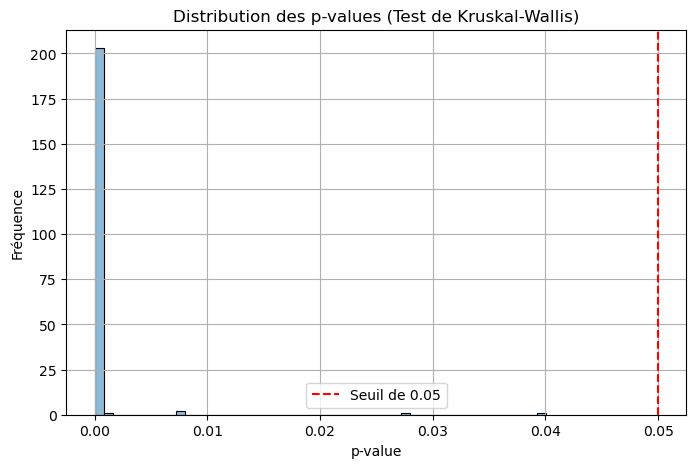

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(p_values.values(), bins=50, kde=False, color="royalblue")  # Histogramme avec densité
plt.axvline(x=0.05, color='red', linestyle='dashed', label="Seuil de 0.05")
plt.xlabel("p-value")
plt.ylabel("Fréquence")
plt.title("Distribution des p-values (Test de Kruskal-Wallis)")
plt.legend()
plt.grid()
plt.show()

Toutes les pvalues sont inférieures à 5%. Il n'y a donc systématiquement rejet de l'hypothèse nulle, les features ont un pouvoir discriminant sur le ratio de Sharpe. 

### 3.4. Nouveaux features et traitements

#### 3.4.1. Calcul des rendements

A faire : 
- normaliser les données : calculer mean et std (déjà fait) sur le train set, normaliser le train set. **Normalisation du test set avec les mêmes moy et std que le train set pour eviter effet forward looking**. Rappeler que normaliser est nécessaire car notamment X_2 part un peu npt comment
- calculer les rendements en disant que double intérêt : guérir l'autocorrel (le montrer ?) et c'est plus logique pour le ratio de Sharpe et évite la présence de colonnes de 100.
- ACP pas très pertinent ici ? Fin jsp ça n'a pas l'air d'avoir de sens là sur cette database
- pas de valeurs manquantes donc pas besoin de traiter
- normalement pas de pb de rééquilibrage de la base (au contraire les poids sont équilibrés etc)  

Les features que nous avons à notre disposition sont des séries de prix sur 21 jours. Le label *in fine* étant le ratio de Sharpe, calculé à partir des rendements des stratégies, nous allons modifier nos features de sorte à utiliser des rendements dans le cadre de notre projet. Cette méthode devrait en outre permettre de réduire l'autocorrélation dans nos séries temporelles. Les rendements logarithmiques sont utilisés dans le calcul du ratio de Sharpe, ce sont donc ceux que nous utiliserons ici.

In [21]:
def compute_returns(df):
    # 8 premières colonnes : ID and weights
    train_set_rdt = df.iloc[:, :8].copy()
    
    # Calcul des rendements
    columns_value_strategies = df.columns[8:]
    for i in range(len(columns_value_strategies) - 1):
        current_prices = columns_value_strategies[i]
        next_prices = columns_value_strategies[i + 1]
        col_names = f"rendement_{df.columns[i+9]}" # ou simplement col_actuelle pour garder le même nom
        train_set_rdt[col_names] = np.log(df[next_prices] / df[current_prices])
    
    return train_set_rdt

# Dataframe avec poids et rendements
train_set_rdt = compute_returns(train_set_clean)
cols_rdt_20 = [col for col in train_set_rdt.columns if "lag_20" in col]
# On retire les colonnes "lag_20" car elles sont le résultat du calcul ln(X_i_lag_0/ X_j_lag_20)
train_set_rdt = train_set_rdt.drop(columns=cols_rdt_20)

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set_rdt[col_names] = np.log(df[next_prices] / df[current_prices])
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set_rdt[col_names] = np.log(df[next_prices] / df[current_prices])
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [22]:
train_set_rdt

,ID,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,...,rendement_X_3_lag_9,rendement_X_3_lag_8,rendement_X_3_lag_7,rendement_X_3_lag_6,rendement_X_3_lag_5,rendement_X_3_lag_4,rendement_X_3_lag_3,rendement_X_3_lag_2,rendement_X_3_lag_1,rendement_X_3_lag_0
0,1.0,0.00,0.00,0.00,0.40,0.25,0.00,0.35,-0.000877,0.000482,...,0.006313,0.000273,0.000547,0.001366,-0.003829,-0.002195,-0.002200,-0.000276,0.000276,0.002497
1,2.0,0.85,0.00,0.00,0.15,0.00,0.00,0.00,-0.005197,0.007191,...,-0.001336,0.002076,-0.002670,0.004741,0.002215,-0.003250,0.000000,-0.006235,-0.003132,0.002238
2,3.0,0.00,0.00,0.70,0.05,0.25,0.00,0.00,0.001245,-0.001012,...,0.001197,0.001941,0.000149,0.005059,0.001335,0.002664,-0.002368,0.001037,0.002365,-0.003846
3,4.0,0.00,0.55,0.05,0.00,0.00,0.00,0.40,0.000000,-0.005940,...,0.005515,-0.001835,0.001224,0.004271,-0.001828,0.005777,0.000000,0.003935,0.000905,-0.000604
4,5.0,0.10,0.00,0.00,0.00,0.00,0.00,0.90,0.008270,0.003459,...,0.000000,-0.003398,0.005657,0.005625,0.003040,0.002553,-0.001116,0.000638,0.000797,-0.000797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,9995.0,0.50,0.00,0.00,0.45,0.00,0.00,0.05,0.001336,0.000667,...,0.004250,0.008446,0.000561,0.004473,0.009715,-0.005262,-0.002224,0.000834,0.006652,-0.000553
9533,9996.0,0.50,0.00,0.15,0.35,0.00,0.00,0.00,0.008270,0.003459,...,0.000000,-0.003398,0.005657,0.005625,0.003040,0.002553,-0.001116,0.000638,0.000797,-0.000797
9534,9997.0,0.10,0.00,0.00,0.00,0.00,0.65,0.25,0.000000,-0.000181,...,-0.002224,0.000318,-0.007981,0.003519,-0.000319,0.001596,-0.007042,-0.002573,-0.005166,0.000324
9535,9998.0,0.00,0.00,0.00,0.15,0.15,0.00,0.70,-0.000145,0.000342,...,0.000290,0.000146,0.003773,-0.001885,-0.001017,-0.006558,0.004813,0.001018,0.000436,0.003191


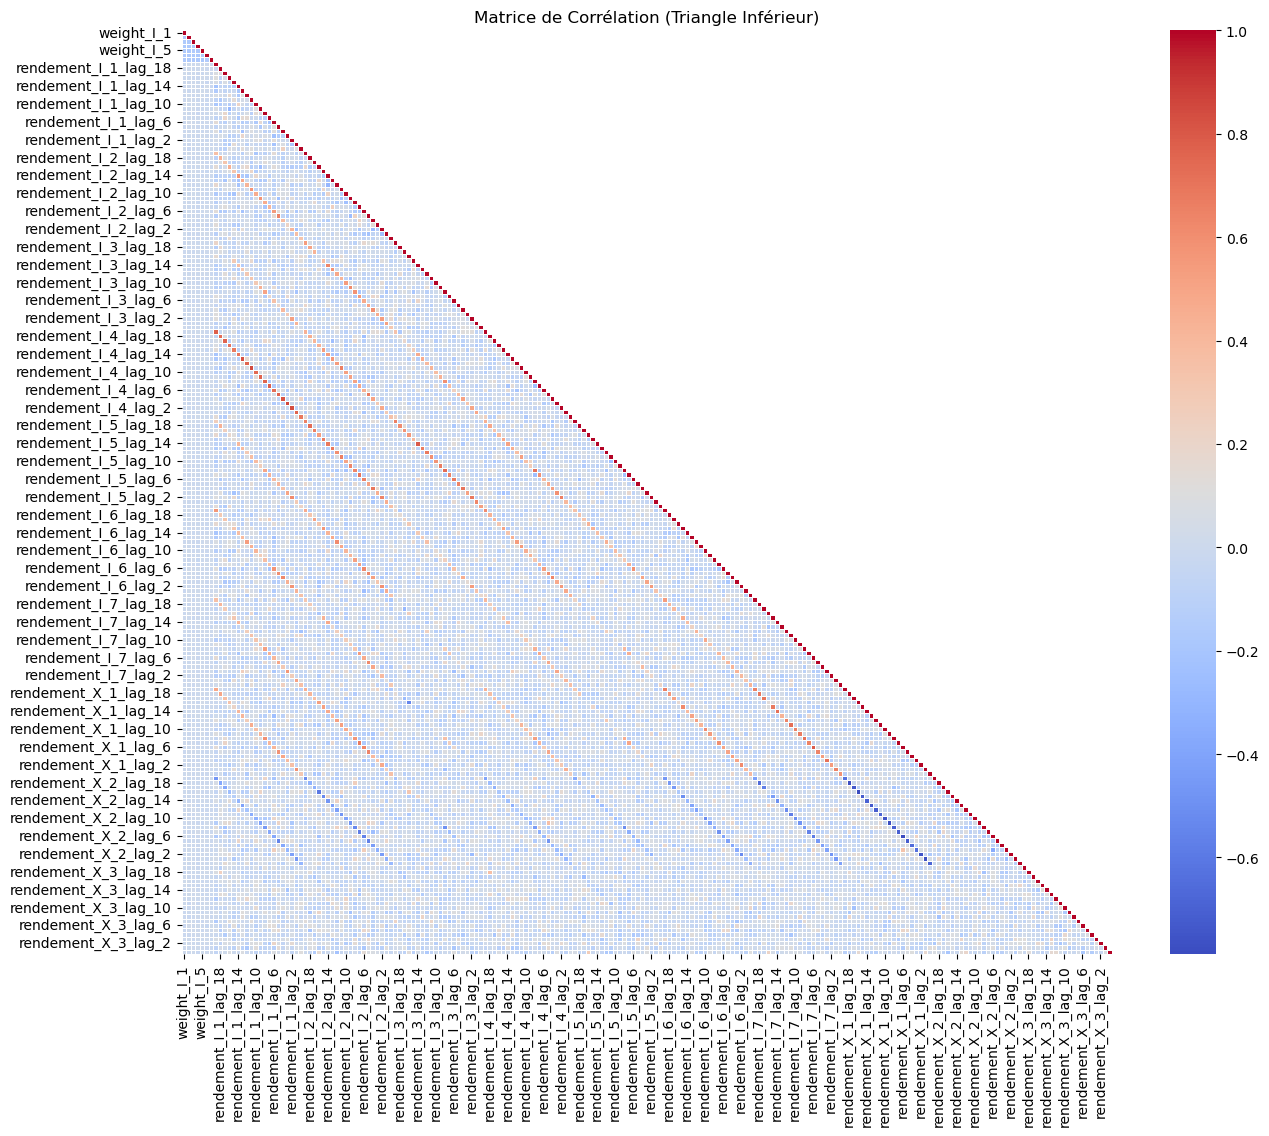

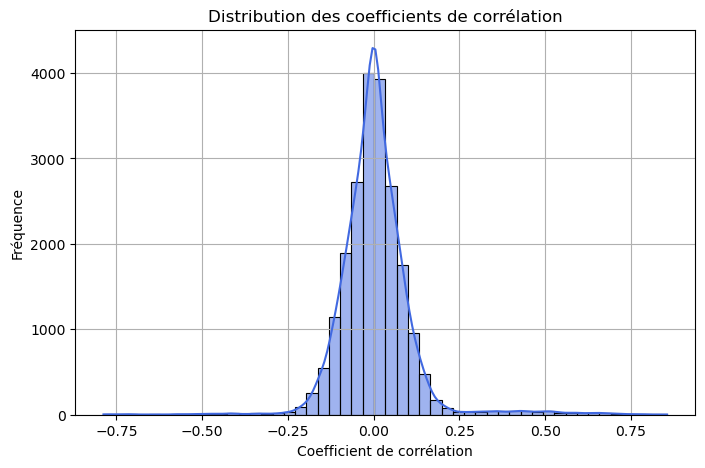

In [23]:
# Masque pour afficher uniquement la partie inférieure
train_correl_returns = train_set_rdt.drop(columns = "ID").corr() 
mask_returns = np.triu(np.ones_like(train_correl_returns, dtype=bool), k=1)
# Heatmap 
plt.figure(figsize=(15, 12))
sns.heatmap(train_correl_returns, mask=mask_returns, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Matrice de Corrélation (Triangle Inférieur)")
plt.show()

# Histogramme
correlation_returns = train_correl_returns.values[mask_returns]
plt.figure(figsize=(8,5))
sns.histplot(correlation_returns, bins=50, kde=True, color="royalblue")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Fréquence")
plt.title("Distribution des coefficients de corrélation")
plt.grid()
plt.show()

Nous observons bien la disparition du phénomène d'autocorrélation que la précédente heatmap triangulaire affichait. Nos features ne sont plus autocorrélés. Le passage en rendements n'a également pas accentué des corrélations particulières inter-features. 

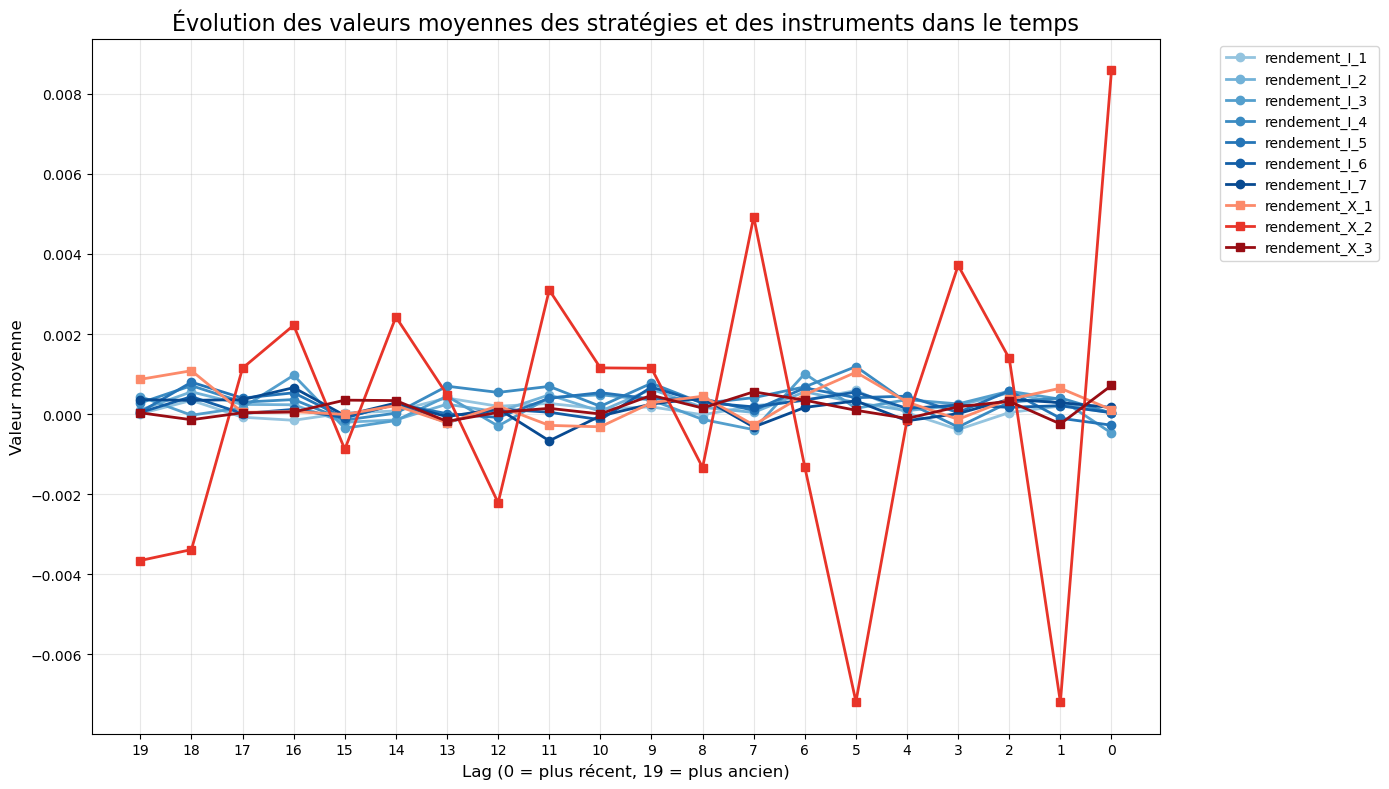

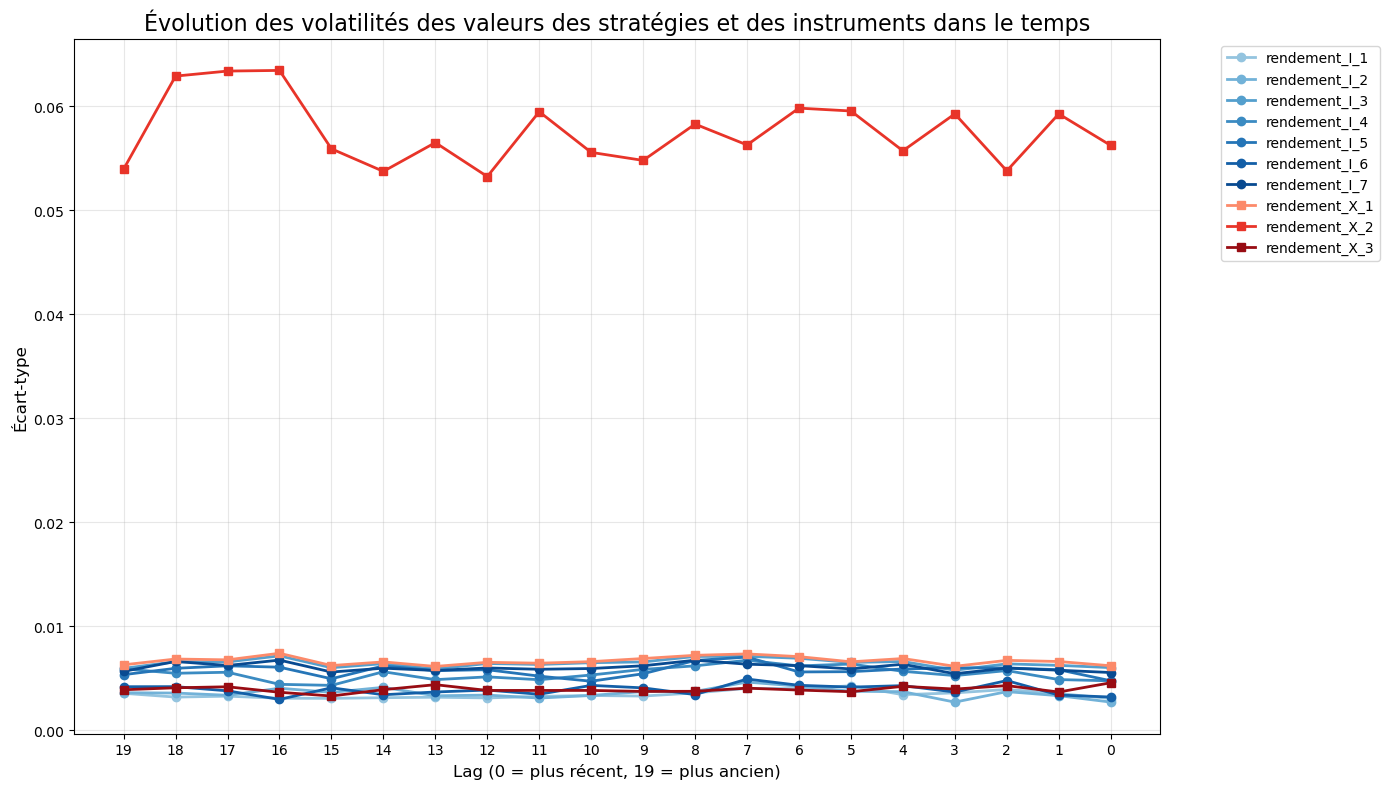

In [24]:
descriptive_stat_rdt = train_set_rdt.drop(columns="ID").describe()
means_by_element_rdt = extract_by_element_and_lag('mean',descriptive_stat_rdt)
volatility_by_element_rdt = extract_by_element_and_lag('std', descriptive_stat_rdt)

# Dans nos données, lag_19 correspond aux données les plus anciennes, lag_0 les données les plus récentes.
# Pour que les graphiques aient un sens logique, on doit inverser cela.
time_periods_rdt = sorted(means_by_element_rdt['lag'].unique())
time_map_rdt = {lag: 19-lag for lag in time_periods_rdt}  # lag_19 = temps 0

# On ajoute une colonne 'time' représentant le temps (inversé par rapport au lag)
means_by_element_rdt['time'] = means_by_element_rdt['lag'].map(time_map)

# On s'assure de ne récupérer que les valeurs des stratégies ou instruments
I_elements = [f'rendement_I_{i}' for i in range(1, 8)]
X_elements = [f'rendement_X_{i}' for i in range(1, 4)]
all_elements_rdt = I_elements + X_elements
filtered_means_rdt = means_by_element_rdt[means_by_element_rdt['element'].isin(all_elements_rdt)]
filtered_vol_rdt = volatility_by_element_rdt[volatility_by_element_rdt['element'].isin(all_elements_rdt)]

# On crée les graphiques des moyennes et des volatiltés
chart1 = create_line_chart(filtered_means_rdt, 'mean',  I_elements, X_elements, 
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
    )

chart2 = create_line_chart(filtered_vol_rdt, 'std', I_elements, X_elements, 
    'Évolution des volatilités des valeurs des stratégies et des instruments dans le temps',
    'Écart-type')

plt.show()

#### 3.4.2. Feature engineering

Nous cherchons à prédire le ratio de Sharpe d'un ensemble de stratégie. Ce dernier étant calculé depuis les rendements journaliers, faire des prédictions en ayant entraîné le modèle sur la base de ces rendements n'aurait pas vraiment d'intérêt. C'est pourquoi, il convient de créer un certain nombre de features à partir de ces rendements afin de capturer des dynamiques sous-jacentes plus complexes, qui nous permettront ensuite d'entraîner notre modèle. En plus des rendements journaliers, nous proposons les features suivants : 
- covariances entre les rendements des stratégies, entre les rendements des indicateurs économiques et entre les rendements stratégies et les rendements indicateurs économiques (cela permettra de capturer de potentielles dynamiques sous-jacentes),
- volatilités des rendements (mesure de risque au dénominateur du ratio de Sharpe),
- moyenne mobile hebdomadaire des rendements (peut aider à capturer des tendances court-termistes tout en réduisant le bruit)
- skewness et kurtosis des rendements (permet d'identifier des stratégies qui performent bien grâce à des valeurs extrêmes importantes de celles qui performent régulièrement. Par exemple, deux stratégies peuvent avoir le même ratio de Sharpe, mais l'une présente une distribution des rendements leptokurtique asymétrique à gauche et donc avec des drawdowns potentiellement larges et réguliers, l'autre symétrique avec faible kurtosis),
- l'indice Herfindahl-Hirschman (HHI) comme mesure de la diversification (permet de voir si le ratio de Sharpe est meilleur lorsque l'AUM est alloué de manière diversifié ou non) : 
$$
HHI = \sum_{i=1}^N \omega_i^2, \quad 0 < HHI \leq 1 \\
\begin{cases}
HHI = 1 : \text{ portefeuille totalement concentré} \\
HHI = \frac{1}{N} : \text{ portefeuille équipondéré}
\end{cases}
$$

In [ ]:
def feature_engineering(df, nb_strat=7, nb_indic=3, nb_days=20, window=5):
    """
    Fonction unifiée qui calcule tous les features (hors HHI) pour les stratégies et indicateurs 
    en une seule passe, réduisant considérablement le temps d'exécution.
    
    Métriques calculées:
    - Covariances entre stratégies, indicateurs, et stratégies-indicateurs
    - Volatilités des stratégies et indicateurs
    - Moyennes mobiles hebdomadaires
    - Skewness et kurtosis
    
    Arguments:
    -----------
        df: DataFrame contenant les rendements (200 colonnes : 20 * 7 pour les stratégies et 20 * 3 pour les indicateurs)
        nb_strat: Nombre de stratégies (7 par défaut)
        nb_indic: Nombre d'indicateurs (3 par défaut)
        nb_days: Nombre de jours de rendements (20 par défaut)
        window: Taille de la fenêtre pour la moyenne mobile (5 jours par défaut)
    
    Résultat:
    -----------
        DataFrame contenant toutes les métriques calculées pour chaque observation. 
        On a : 
            - pour les covariances, on ne prend que la partie triangulaire haute sans les variances. Cela donne
                45 colonnes (combinaisons entre les stratégies (variance exclue) = 7 * 6/2 = 21,
                combinaisons entre les indicateurs : 3 * 2/2 = 3, combinaisons entre les stratégies et indicateurs : 7 * 3 = 21)
            - pour les volatilités, 10 colonnes (7 + 3)
            - pour les skewness et kurtosis, 20 colonnes ((7+3)*2)
            - pour les moyennes mobiles, 160 colonnes ((21 - 5 jours) * (7 + 3)).
        Cela fait un total de 235 colonnes
    """
    nb_rows = df.shape[0]
    
    # Création de paires et de noms de colonnes 
    strat_cols = df.columns[:nb_strat * nb_days].tolist()
    indic_cols = df.columns[nb_strat * nb_days:(nb_strat + nb_indic) * nb_days].tolist()
    
    # 1. Définition des colonnes pour les covariances
    strat_pairs = list(combinations(range(1, nb_strat+1), 2))
    strat_strat_cols = [f'cov_I_{i}_I_{j}' for i, j in strat_pairs]
    
    indicator_pairs = list(combinations(range(1, nb_indic+1), 2))
    indic_indic_columns = [f'cov_X_{i}_X_{j}' for i, j in indicator_pairs]
    
    strat_indic_pairs = [(i, j) for i in range(1, nb_strat+1) for j in range(1, nb_indic+1)]
    strat_indic_columns = [f'cov_I_{i}_X_{j}' for i, j in strat_indic_pairs]
    
    # 2. Définition des colonnes pour les volatilités
    vol_columns = [f'vol_I_{s}' for s in range(1, nb_strat+1)] + [f'vol_X_{i}' for i in range(1, nb_indic+1)]
    
    # 3. Définition des colonnes pour le skewness et kurtosis
    skew_columns = [f'skew_I_{s}' for s in range(1, nb_strat+1)] + [f'skew_X_{i}' for i in range(1, nb_indic+1)]
    kurt_columns = [f'kurt_I_{s}' for s in range(1, nb_strat+1)] + [f'kurt_X_{i}' for i in range(1, nb_indic+1)]
    
    # 4. Définition des colonnes pour les moyennes mobiles
    nb_ma = nb_days - window + 1
    ma_columns = []
    for s in range(1, nb_strat+1):
        for w in range(1, nb_ma+1):
            ma_columns.append(f'ma_I_{s}_w{w}')
    for i in range(1, nb_indic+1):
        for w in range(1, nb_ma+1):
            ma_columns.append(f'ma_X_{i}_w{w}')
    
    # Combinaison de toutes les colonnes pour le tableau final
    all_columns = strat_strat_cols + indic_indic_columns + strat_indic_columns + vol_columns + skew_columns + kurt_columns + ma_columns
    results = pd.DataFrame(index=range(nb_rows), columns=all_columns)
    
    # Précalcul des indices pour éviter des calculs répétitifs
    strat_indices = {}
    indic_indices = {}
    
    for s in range(1, nb_strat+1):
        strat_cols_s = [col for col in strat_cols if f'I_{s}_' in col or col.startswith(f'I_{s}_')]
        if not strat_cols_s:
            strat_cols_s = strat_cols[(s-1)*nb_days:s*nb_days]
        strat_indices[s] = [df.columns.get_loc(col) for col in strat_cols_s]
    
    for i in range(1, nb_indic+1):
        indic_cols_i = [col for col in indic_cols if f'X_{i}_' in col or col.startswith(f'X_{i}_')]
        if not indic_cols_i:
            indic_cols_i = indic_cols[(i-1)*nb_days:i*nb_days]
        indic_indices[i] = [df.columns.get_loc(col) for col in indic_cols_i]
    
    # Calcul de toutes les métriques
    for row_idx in range(nb_rows):
        row_values = df.iloc[row_idx].values
        
        # Extraction des données pour chaque stratégie et indicateur (une seule fois)
        strat_data = {}
        indic_data = {}
        
        for s in range(1, nb_strat+1):
            strat_data[s] = row_values[strat_indices[s]]
        
        for i in range(1, nb_indic+1):
            indic_data[i] = row_values[indic_indices[i]]
        
        # 1. Calcul des covariances
        # Entre stratégies
        for col_idx, (s1, s2) in enumerate(strat_pairs):
            cov = np.cov(strat_data[s1], strat_data[s2])[0, 1]
            results.loc[row_idx, strat_strat_cols[col_idx]] = cov
        
        # Entre indicateurs
        for col_idx, (i1, i2) in enumerate(indicator_pairs):
            cov = np.cov(indic_data[i1], indic_data[i2])[0, 1]
            results.loc[row_idx, indic_indic_columns[col_idx]] = cov
        
        # Entre stratégies et indicateurs
        for col_idx, (s, i) in enumerate(strat_indic_pairs):
            cov = np.cov(strat_data[s], indic_data[i])[0, 1]
            results.loc[row_idx, strat_indic_columns[col_idx]] = cov
        
        # 2. Calcul des volatilités (on peut réutiliser les variances calculées précédemment)
        for s in range(1, nb_strat+1):
            vol = np.std(strat_data[s], ddof=1)
            results.loc[row_idx, f'vol_I_{s}'] = vol
        
        for i in range(1, nb_indic+1):
            vol = np.std(indic_data[i], ddof=1)
            results.loc[row_idx, f'vol_X_{i}'] = vol
        
        # 3. Calcul du skewness et kurtosis
        for s in range(1, nb_strat+1):
            results.loc[row_idx, f'skew_I_{s}'] = stats.skew(strat_data[s])
            results.loc[row_idx, f'kurt_I_{s}'] = stats.kurtosis(strat_data[s], fisher=True)
        
        for i in range(1, nb_indic+1):
            results.loc[row_idx, f'skew_X_{i}'] = stats.skew(indic_data[i])
            results.loc[row_idx, f'kurt_X_{i}'] = stats.kurtosis(indic_data[i], fisher=True)
        
        # 4. Calcul des moyennes mobiles
        for s in range(1, nb_strat+1):
            values = strat_data[s]
            for w in range(nb_ma):
                ma = np.mean(values[w:w+window])
                results.loc[row_idx, f'ma_I_{s}_w{w+1}'] = ma
        
        for i in range(1, nb_indic+1):
            values = indic_data[i]
            for w in range(nb_ma):
                ma = np.mean(values[w:w+window])
                results.loc[row_idx, f'ma_X_{i}_w{w+1}'] = ma
    
    return results

def compute_hhi(weights):
    """
    Calcule le HHI pour chaque ligne du DataFrame.
    
    Arguments:
        weights: DataFrame contenant les poids à chaque ligne
    
    Retourne:
        DataFrame avec une colonne 'HHI' contenant les indices calculés
    """
    squared_weights = weights ** 2
    hhi_values = squared_weights.sum(axis=1)
    
    return pd.DataFrame({'HHI': hhi_values}, index=weights.index)

In [26]:
cols_strategies = [col for col in train_set_rdt.columns if "rendement_I" in col ]
cols_indicators = [col for col in train_set_rdt.columns if "X" in col ]
features_train = feature_engineering(train_set_rdt[cols_strategies+cols_indicators])
features_train["HHI"] = compute_hhi(train_set_rdt.iloc[:,1:8])
weight_columns = train_set_rdt.iloc[:,1:8]
features_train = pd.concat([weight_columns, features_train], axis=1)
features_train = features_train.apply(pd.to_numeric, errors='coerce')
display(features_train)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,cor_I_1_I_2,cor_I_1_I_3,cor_I_1_I_4,...,ma_X_3_w8,ma_X_3_w9,ma_X_3_w10,ma_X_3_w11,ma_X_3_w12,ma_X_3_w13,ma_X_3_w14,ma_X_3_w15,ma_X_3_w16,HHI
0,0.00,0.00,0.00,0.40,0.25,0.00,0.35,3.154432e-06,-3.824492e-07,0.000006,...,0.001593,0.001371,0.001590,0.000934,-0.000768,-0.001262,-0.001427,-0.001645,-0.000379,0.345
1,0.85,0.00,0.00,0.15,0.00,0.00,0.00,7.179584e-06,9.889341e-06,0.000016,...,0.001010,0.000863,0.001394,0.001005,0.000623,0.000207,-0.000506,-0.002080,-0.002076,0.745
2,0.00,0.00,0.70,0.05,0.25,0.00,0.00,-9.732619e-06,-1.013412e-06,0.000002,...,-0.000268,0.000298,0.001849,0.001936,0.002230,0.001368,0.001545,0.001007,-0.000030,0.555
3,0.00,0.55,0.05,0.00,0.00,0.00,0.40,-2.670849e-06,-4.075037e-06,0.000005,...,0.000552,0.000367,0.001589,0.001469,0.001522,0.001889,0.002431,0.001758,0.002003,0.465
4,0.10,0.00,0.00,0.00,0.00,0.00,0.90,1.152495e-05,1.031237e-05,0.000021,...,0.001301,0.002628,0.002516,0.002185,0.002695,0.003152,0.002148,0.001182,0.000415,0.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,0.50,0.00,0.00,0.45,0.00,0.00,0.05,3.460857e-07,-6.870503e-06,0.000011,...,0.002880,0.002822,0.003716,0.005489,0.003587,0.001453,0.001507,0.001943,-0.000111,0.455
9533,0.50,0.00,0.15,0.35,0.00,0.00,0.00,1.152495e-05,1.031237e-05,0.000021,...,0.001301,0.002628,0.002516,0.002185,0.002695,0.003152,0.002148,0.001182,0.000415,0.395
9534,0.10,0.00,0.00,0.00,0.00,0.65,0.25,2.047231e-05,4.439389e-05,0.000046,...,-0.001962,-0.003495,-0.002223,-0.001337,-0.000573,-0.002045,-0.000964,-0.002701,-0.002572,0.495
9535,0.00,0.00,0.00,0.15,0.15,0.00,0.70,2.087735e-05,3.425456e-05,0.000049,...,-0.000116,0.000900,0.000843,0.000262,-0.001108,-0.000175,-0.000725,-0.000261,0.000580,0.535


Après ces calculs, on constate que certaines colonnes affichent des valeurs vides (NaN). Plus précisément, on identifie qu'elles sont présentes dans les skewness et kurtosis des rendements d'il y a 4 et 6 jours.  

In [27]:
pd.options.display.max_rows = None
print(f"Le fichier contenant les données d'entraînement contient {features_train.isnull().sum()} données manquantes.")
features_train = features_train.dropna(axis = 1)
print(f"Le fichier contenant les données d'entraînement contient {features_train.isnull().sum()} données manquantes.")


Le fichier contenant les données d'entraînement contient weight_I_1        0
weight_I_2        0
weight_I_3        0
weight_I_4        0
weight_I_5        0
weight_I_6        0
weight_I_7        0
cor_I_1_I_2       0
cor_I_1_I_3       0
cor_I_1_I_4       0
cor_I_1_I_5       0
cor_I_1_I_6       0
cor_I_1_I_7       0
cor_I_2_I_3       0
cor_I_2_I_4       0
cor_I_2_I_5       0
cor_I_2_I_6       0
cor_I_2_I_7       0
cor_I_3_I_4       0
cor_I_3_I_5       0
cor_I_3_I_6       0
cor_I_3_I_7       0
cor_I_4_I_5       0
cor_I_4_I_6       0
cor_I_4_I_7       0
cor_I_5_I_6       0
cor_I_5_I_7       0
cor_I_6_I_7       0
cor_X_1_X_2       0
cor_X_1_X_3       0
cor_X_2_X_3       0
cor_I_1_X_1       0
cor_I_1_X_2       0
cor_I_1_X_3       0
cor_I_2_X_1       0
cor_I_2_X_2       0
cor_I_2_X_3       0
cor_I_3_X_1       0
cor_I_3_X_2       0
cor_I_3_X_3       0
cor_I_4_X_1       0
cor_I_4_X_2       0
cor_I_4_X_3       0
cor_I_5_X_1       0
cor_I_5_X_2       0
cor_I_5_X_3       0
cor_I_6_X_1       0
cor

On décide de supprimer ces données. En effet, le nombre conséquent de valeurs vides dans ces 4 colonnes rend difficile la justification d'un remplacement par une valeur. De plus, le nombre conséquent de données à notre disposition devrait rendre marginal l'effet de ces suppressions.

#### 3.4.3. Normalisation
Nous normalisons les données afin d'éviter des problèmes d'échelle (par exemple, les poids sont de l'ordre moyen de 14%, alors que les rendements journaliers sont plutôt inférieurs à 1%). Comme nous souhaitons que les poids restent entre 0 et 1, nous faisons une normalisation Min-Max.

In [30]:
def normalize(*arg):
    df = arg[0]
    result = df.copy()
    if len(arg)==1:
        minval, maxval = [], []
        for feature_name in df.columns:
            min_value = df[feature_name].min()
            max_value = df[feature_name].max()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            minval.append(min_value)
            maxval.append(max_value)
        return result, minval, maxval
    else:
        minvals = arg[1]
        maxvals = arg[2]
        for i in range(df.shape[1]):
            result.iloc[:,i] = (df.iloc[:,i] - minvals[i]) / (maxvals[i] - minvals[i])
        return result
    
train_set_rdt, minval, maxval = normalize(train_set_rdt)

Nous appliquons finalement les mêmes changements au test set : 
- on calcule les rendements ;
- avec les valeurs de normalisation du train set (afin d'éviter les effets forward looking), on normalise les données.

In [31]:
test_set_rdt = compute_returns(test_set)
test_set_rdt = test_set_rdt.drop(columns=cols_rdt_20)
test_set_rdt = normalize(test_set_rdt, minval, maxval)

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set_rdt[col_names] = np.log(df[next_prices] / df[current_prices])
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set_rdt[col_names] = np.log(df[next_prices] / df[current_prices])
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\2681122628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

## 4. Sélection du modèle

## 5. Benchmark

La mesure de performance demandée par le challenge est la **mean absolute error** : 
$$
MAE = \frac{1}{N} \sum_{i=1}^n | f(y_i) - f(\hat{y_i})|
$$
avec $f(x) = sign(x) \times e^{-\frac{1}{|x|}}$ une fonction visant à lisser les extrêmes, $y_i$ les vraies valeurs du label et $\hat{y_i}$ les valeurs prédites du label. 

Le benchmark proposé est simplement la moyenne : autrement dit, il s'agit du modèle qui prédit exclusivement la moyenne des ratios de Sharpe du train set. La MAE du benchmark est donc : 
$$
MAE_{bench} = \frac{1}{10000} \sum_{i=1}^n | f(y_i) - f({1.527390})|
$$
(Remarque : le sujet indique d'utiliser la valeur 1.200344, moyenne des ratios de Sharpe du set d'entraînement inital. Comme nous avons supprimé des outliers, nous utilisons la moyenne de notre set d'entraînement nettoyé, 1.527390).


In [32]:
def mean_absolute_error(real_values: pd.Series, predicted_values: pd.Series) -> float:
    """
    Fonction qui calcule la métrique de performance retenue par le challenge, la MAE
    """
    N = len(real_values)
    smoothed_real = real_values.apply(smoothering_function)
    smoothed_predicted = predicted_values.apply(smoothering_function)
    return (1/N) * np.sum(np.abs(smoothed_real - smoothed_predicted))

def smoothering_function(value: float) -> float:
    """
    Fonction lissant les valeurs extrêmes
    """
    return np.sign(value) * np.exp(-1/np.abs(value))

predicted_benchmark = pd.DataFrame({'Predicted': [1.527390] * len(target_values_clean)})
mae_benchmark = mean_absolute_error(target_values_clean["Target"], predicted_benchmark["Predicted"])
print(f"La MAE du benchmark est de {mae_benchmark}")

La MAE du benchmark est de 0.5752965642424244


C:\Users\Giovanni\AppData\Local\Temp\ipykernel_16936\3290446304.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sign(value) * np.exp(-1/np.abs(value))


## 6. Modèle non supervisé si possible

## 7. Modèle supervisé

## 8. Interprétation des modèles

## 9. Modèles de deep learning

## 10. Comparaison des résultats

## 11. XAI